In [158]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [159]:
def modulate_fm(Fs, Fc, max_deviation, s):
    t = np.arange(len(s))
    m = np.exp(1.0j*2*np.pi*(Fc*t + max_deviation*s)/Fs)
    return m

In [160]:
Fs = 100000
Fc = 0
max_deviation = 5000

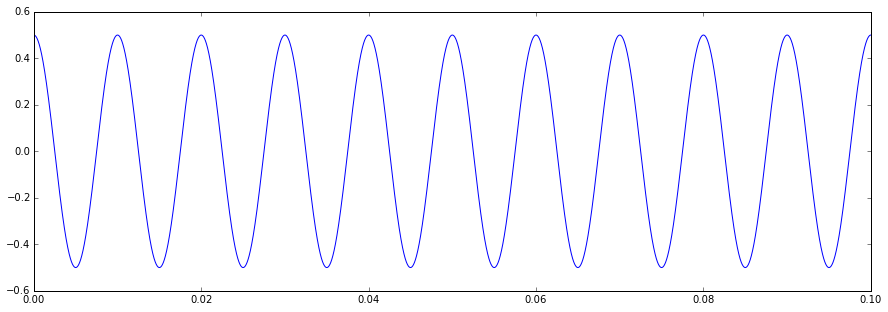

In [161]:
N = 10000
tone = 100
t = np.arange(N+0.0)
signal = 0.5*np.cos(t*2*np.pi*tone/Fs)
plot(t/Fs, signal)

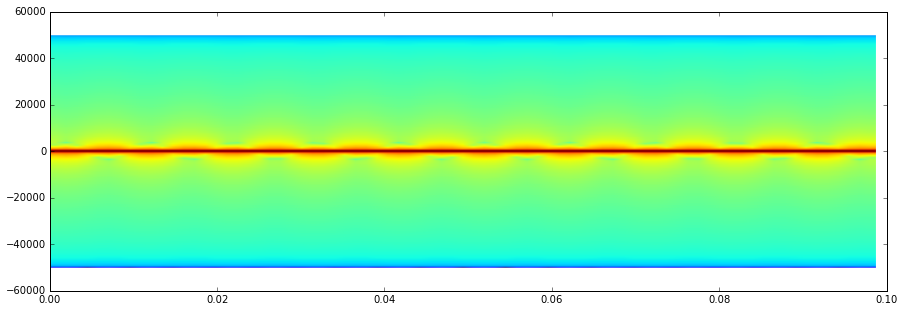

In [162]:
x = modulate_fm(Fs, Fc, max_deviation, signal)
specgram(x, Fs=Fs); None

In [163]:
def demod_quad_janky(x):
    y = np.conj(x[:-1])*x[1:]
    return np.imag(y)

In [164]:
def demod_quad_proper(x):
    y = np.conj(x[:-1])*x[1:]
    return np.arctan2(np.imag(y), np.real(y))

In [165]:
k = np.pi*Fs/max_deviation*10

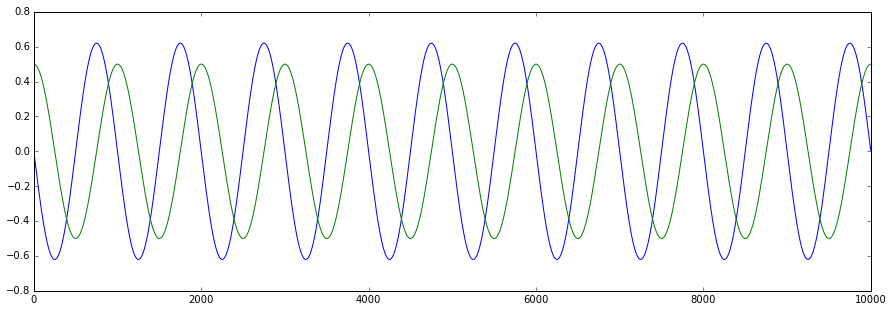

In [166]:
y_janky = demod_quad_janky(x)
plot(y_janky*k)
plot(signal)

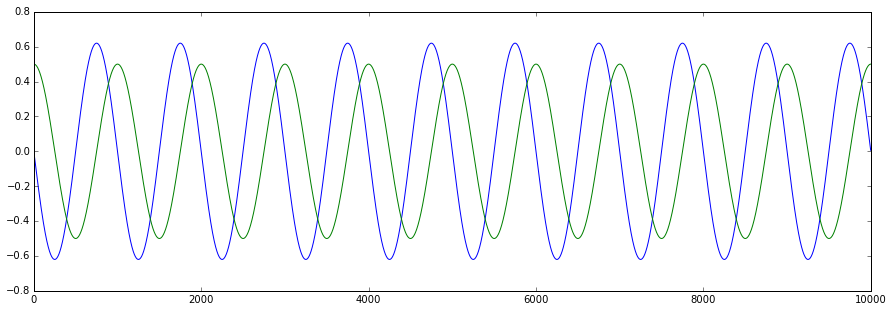

In [167]:
y_proper = demod_quad_proper(x)
plot(y_proper*k)
plot(signal)

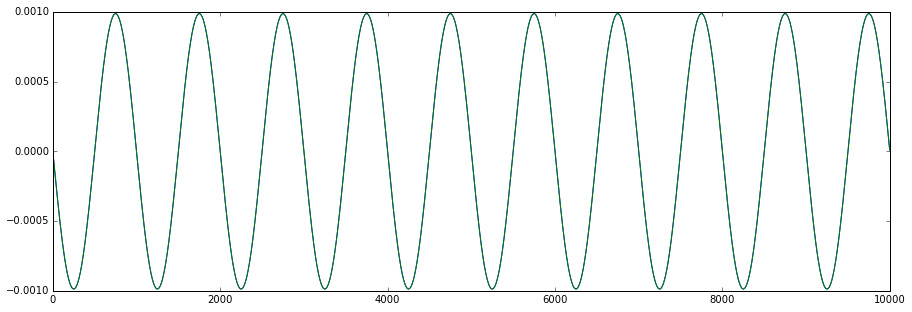

In [168]:
plot(y_janky)
plot(y_proper)

(0, 10000)

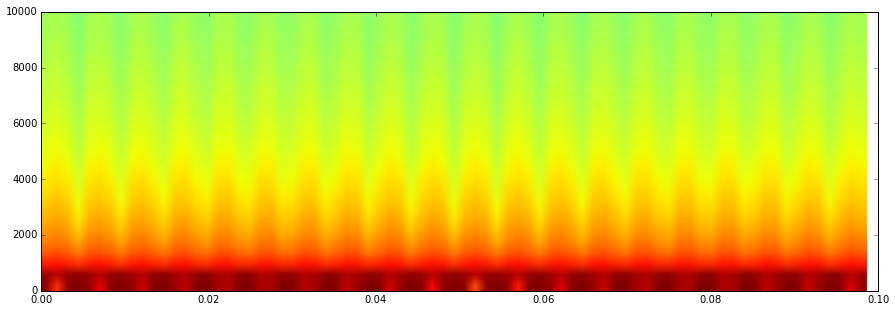

In [174]:
specgram(signal, Fs=Fs); None
ylim(0,10000)

(0, 10000)

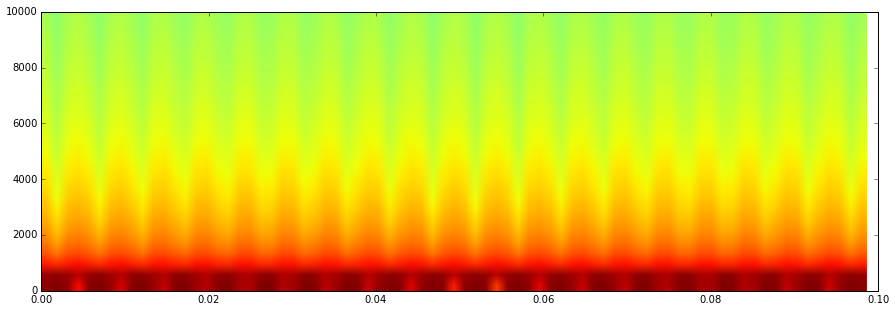

In [175]:
specgram(y_janky, Fs=Fs); None
ylim(0,10000)

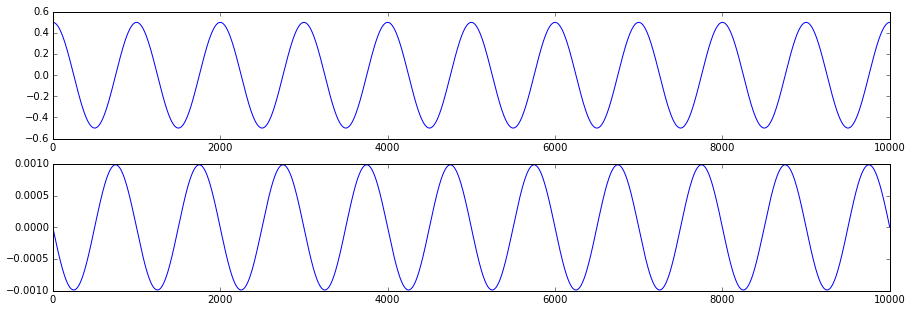

In [171]:
figure(figsize=(15,5))
subplot(2,1,1)
plot(signal)
subplot(2,1,2)
plot(y_janky)

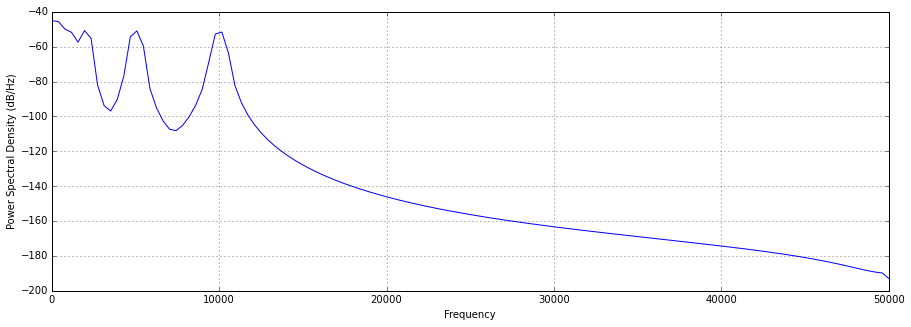

In [239]:
noise = numpy.random.uniform(low=-0.5, high=0.5, size=100000)
t = np.arange(100000.0)

freqs = [ 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

noise = np.zeros_like(t)
for f in freqs:
    noise += 0.1 * np.cos(t*2*np.pi*f/Fs)
psd(noise, Fs=Fs); None

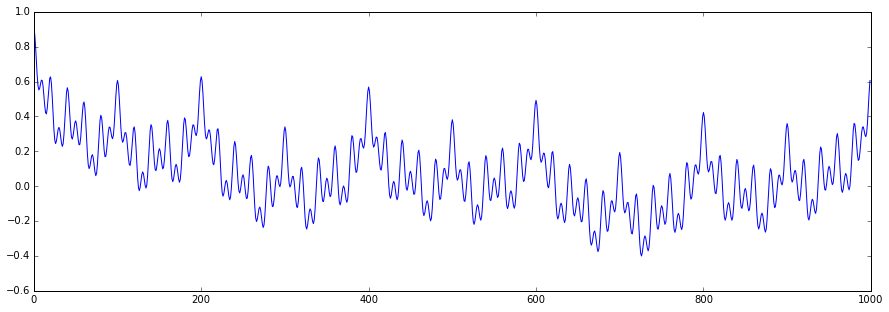

In [240]:
plot(noise[0:1000])

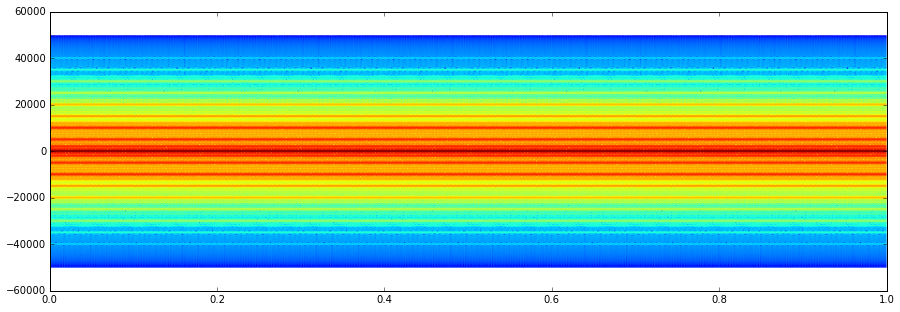

In [241]:
noise_mod = modulate_fm(Fs, 0, 20000, noise)
specgram(noise_mod, Fs=Fs); None

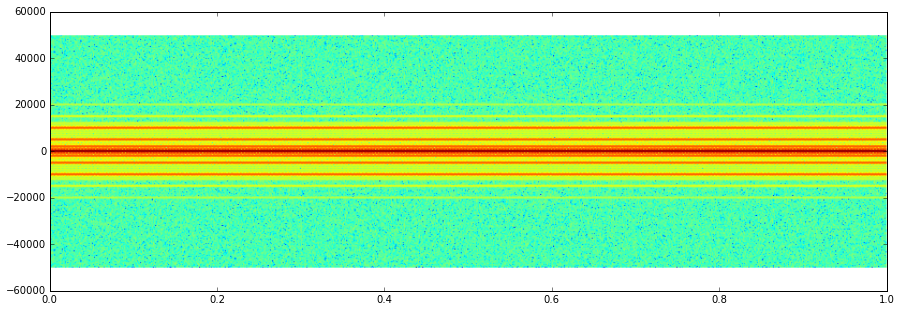

In [242]:
noise_mod_noisy = noise_mod + np.random.normal(scale=0.005, size=len(noise_mod))
specgram(noise_mod_noisy, Fs=Fs); None

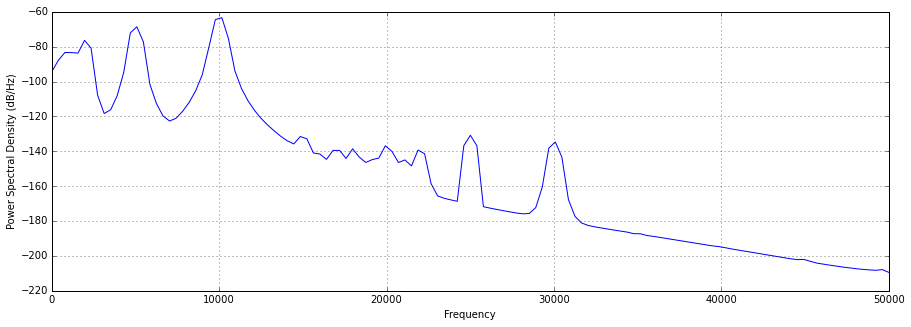

In [248]:
noise_demod = demod_quad_janky(noise_mod) / 3
psd(noise_demod, Fs=Fs); None

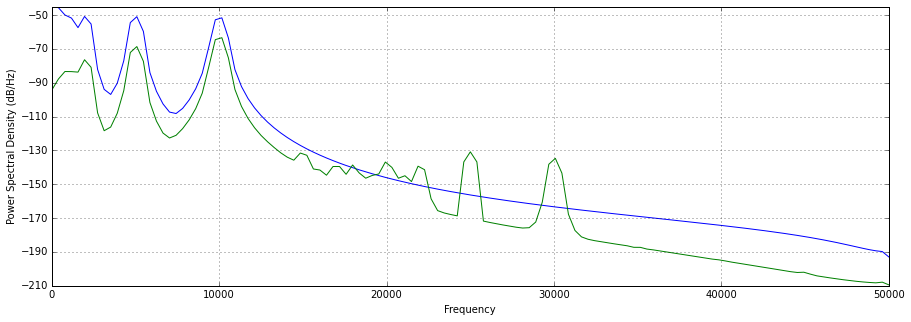

In [249]:
psd(noise, Fs=Fs)
psd(noise_demod, Fs=Fs); None

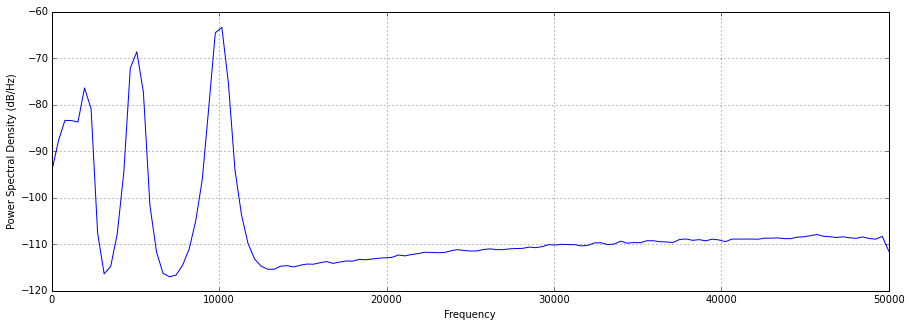

In [250]:
noise_demod_noisy = demod_quad_janky(noise_mod_noisy) / 3
psd(noise_demod_noisy, Fs=Fs); None

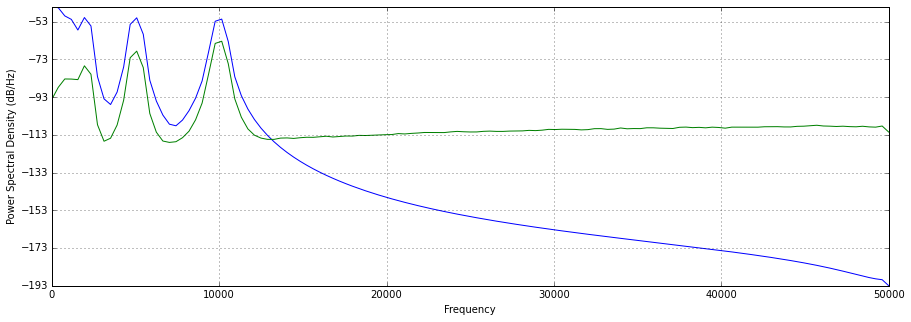

In [251]:
psd(noise, Fs=Fs)
psd(noise_demod_noisy, Fs=Fs); None

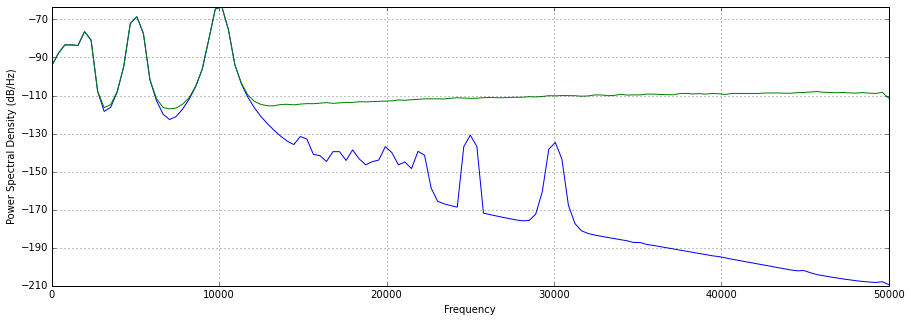

In [252]:
psd(noise_demod, Fs=Fs)
psd(noise_demod_noisy, Fs=Fs); None